# TODO
- Save max acc epoch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os


In [2]:
print( f"TensorFlow {tf.__version__}" )
import sys
print( f"Python {sys.version}\n" )


TensorFlow 2.6.0
Python 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]



In [3]:
model_input_w = 224
model_input_h = 224

# Read data

In [4]:
def read_infer_label(path, size= (300,300), batch_size= 2):
    # directory = './resize/'
    # directory = './raw_data/'
    tf_raw_data = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode= 'categorical',#'categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=size,
        shuffle=True,
        seed=42,
        # validation_split=0.2,
        # validation_split={0.2,0.2,0.2,0.2},
        # subset=None,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )
    return tf_raw_data

In [5]:
raw_train = read_infer_label('./raw_data_train/', size= (model_input_w, model_input_h), batch_size= 100)
raw_test = read_infer_label('./raw_data_test/', size= (model_input_w, model_input_h), batch_size= 100)

Found 703 files belonging to 4 classes.
Found 173 files belonging to 4 classes.


In [47]:
import os

# Set the directory containing your dataset
data_directory = './raw_data_train'

# Initialize an empty dictionary to store the counts for each class
class_counts = {}

# Iterate over the subdirectories in the main data directory
for class_name in os.listdir(data_directory):
    class_path = os.path.join(data_directory, class_name)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        class_counts[class_name] = class_count

# Display the counts for each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Class: adventure, Count: 73
Class: cruiser, Count: 204
Class: dirt, Count: 193
Class: sport, Count: 234


# Pre processing

## Data Augmentation

In [48]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(model_input_w, model_input_h,3)),
                                        #   tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', name='rand_flip'),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.2, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomCrop(model_input_w, model_input_h, seed=42, name= 'rans_crop'),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

dataaug.summary()

Model: "dataaug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rand_flip (RandomFlip)       (None, 224, 224, 3)       0         
_________________________________________________________________
rand_trans (RandomTranslatio (None, 224, 224, 3)       0         
_________________________________________________________________
rand_rot (RandomRotation)    (None, 224, 224, 3)       0         
_________________________________________________________________
rans_crop (RandomCrop)       (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [49]:
# RandomTranslation ไม่เอา constant
# RamdomRotatation <- เลือก องศา dirt
# RandomFlip <- มีทุกอัน ซ้ายขวา

# RandomCrop / Zoom
# hight, width <- 
# 

In [50]:
# Define a function to apply the sequential pipeline to the data
def apply_pipeline(image, label):
    return dataaug(image), label

# Apply the sequential pipeline to the dataset
augmented_data = raw_train.map(apply_pipeline)

# Iterate over the dataset and display the augmented images
# c = 0
# for images, labels in augmented_data:
#     for i in range(len(images)):
#         plt.imshow(images[i] / 255)  # Assuming the images are in the range [0, 255]
#         plt.title(f"Label: {labels[i]}")
#         plt.show()
#         # c+=1
#         continue
#         # if c > 10:
#         #     break
#         # break
#     # end
#     break
    

In [51]:
## Normal

# Concat Raw and Augemented data

In [52]:
full_train = raw_train.concatenate(augmented_data)

In [53]:
batch = full_train.as_numpy_iterator().next()
print('total data :', len(batch) * len(full_train))
print('N batch :', len(batch))
print('data shape :',batch[0][0].shape)
print('label example : ',batch[1][0])

total data : 32
N batch : 2
data shape : (224, 224, 3)
label example :  [0. 1. 0. 0.]


# Transfer learning

In [54]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [13]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)

In [14]:
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [15]:
resnet_fz =resnet_model

for layer in resnet_model.layers:
    layer.trainable = False

In [16]:
inputs = tf.keras.Input(shape= (224,224,3))
x = resnet_fz(inputs, training= False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation= 'relu')(x)

outputs = tf.keras.layers.Dense(4, activation= 'softmax')(x)


In [17]:
transfer_model = tf.keras.Model(inputs, outputs)

In [18]:
transfer_model.compile(optimizer= 'adam',
                     loss= 'categorical_crossentropy',
                     metrics= ['accuracy'])

In [19]:
type(inputs)

keras.engine.keras_tensor.KerasTensor

In [20]:
print(type(outputs))

<class 'keras.engine.keras_tensor.KerasTensor'>


## Train with callback method

In [84]:
from tensorflow.keras.callbacks import Callback

class MaxAccuracyEpochScoreSaver(Callback):
    def __init__(self):
        super(MaxAccuracyEpochScoreSaver, self).__init__()
        self.max_val_accuracy = 0.0
        self.max_val_epoch = 0
        self.scores = {}

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs['val_accuracy']
        if current_val_accuracy > self.max_val_accuracy:
            self.max_val_accuracy = current_val_accuracy
            self.max_val_epoch = epoch + 1
            self.scores = {
                'Epoch': self.max_val_epoch,
                'Training Loss': logs['loss'],
                'Training Accuracy': logs['accuracy'],
                'Validation Loss': logs['val_loss'],
                'Validation Accuracy': logs['val_accuracy']
            }

    def on_train_end(self, logs=None):
        print("Max Accuracy Epoch Scores:")
        for key, value in self.scores.items():
            print(f"{key}: {value}")




In [92]:
# Create an instance of the callback
max_accuracy_saver = MaxAccuracyEpochScoreSaver()

# Add the callback to the list of callbacks when fitting the model
transfer_model.fit(full_train, epochs=2, validation_data=raw_test, callbacks=[max_accuracy_saver])

Epoch 1/2
16/16 [==============================] - 25s 1s/step - loss: 0.6258 - accuracy: 0.7383 - val_loss: 1.1059 - val_accuracy: 0.5434
Epoch 2/2
16/16 [==============================] - 24s 1s/step - loss: 0.5757 - accuracy: 0.7710 - val_loss: 1.2220 - val_accuracy: 0.5434
Max Accuracy Epoch Scores:
Epoch: 1
Training Loss: 0.6258313059806824
Training Accuracy: 0.7382645606994629
Validation Loss: 1.105907678604126
Validation Accuracy: 0.5433526039123535


In [96]:
# transfer_model.fit(full_train, epochs= 2)#, validation_data= raw_test)

# Evaluate

In [97]:
loss, acc = transfer_model.evaluate(raw_test)
print('loss :', loss)
print('acc :', acc)



2/2 [==============================] - 2s 280ms/step - loss: 1.2220 - accuracy: 0.5434
loss : 1.222030758857727
acc : 0.5433526039123535


In [98]:
transfer_model.history.history

{}

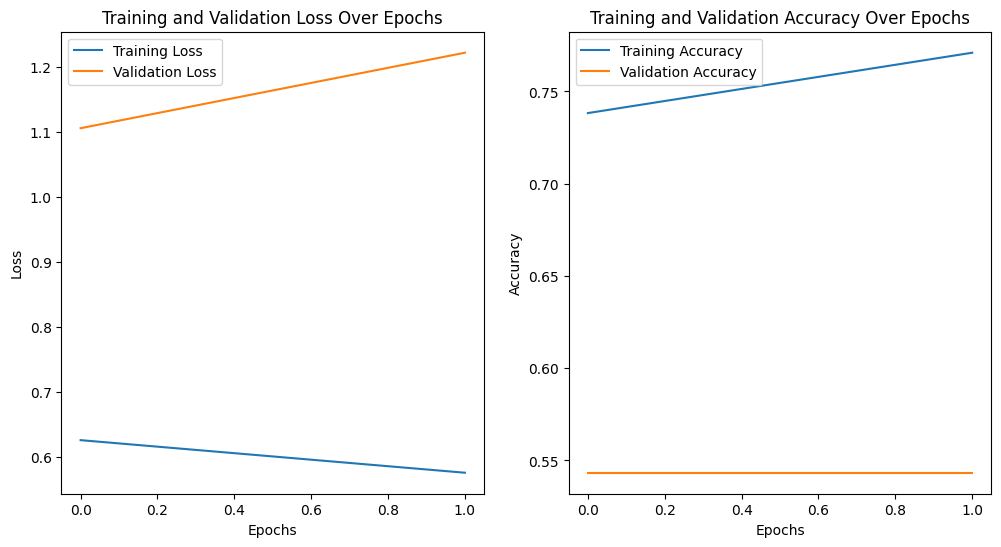

In [93]:
import matplotlib.pyplot as plt

# Assuming 'transfer_model' is the trained model
history = transfer_model.history.history

# Retrieve the training and validation loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Create a plot for training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Create a plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plots
plt.show()


In [23]:
type(i[0].numpy())

NameError: name 'i' is not defined

In [ ]:
for i in raw_test.unbatch():
    print(type(i[0].numpy()))
    break

<class 'numpy.ndarray'>


In [25]:
for _data in raw_test.unbatch():
    print(_data[1])

tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0

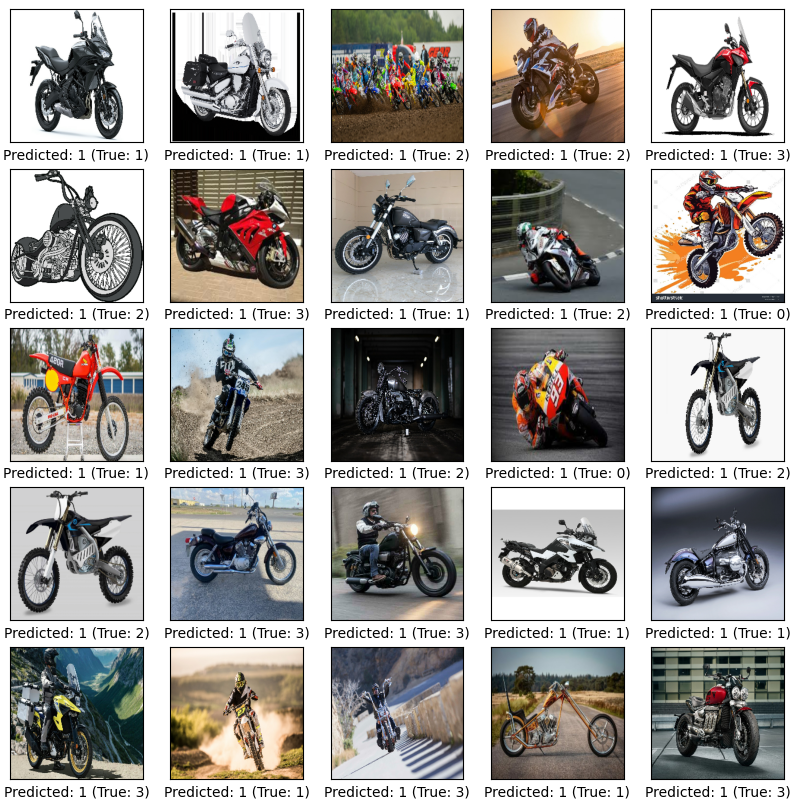

In [ ]:
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            true_label = np.argmax(label)
            plt.xlabel(f"Predicted: {predicted_label} (True: {true_label})")
        else:
            true_label = np.argmax(label)
            plt.xlabel(f"True: {true_label}")
    plt.show()

# Convert the test data to numpy arrays
test_images = np.array([data[0].numpy() for data in raw_test.unbatch()])
test_labels = np.array([data[1].numpy() for data in raw_test.unbatch()])

# Generate predictions on the test images
predictions = transfer_model.predict(raw_test)

# Plot a sample of the test images with their true and predicted labels
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])

In [44]:
print(f'{i:.6f}')

0.000677


In [46]:
for i in transfer_model.predict(raw_test)[1]:
    print(f'{i:.6f}')

0.002387
0.981088
0.016520
0.000004
